In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import streamlit as st
import pandas as pd
import altair as alt

In [3]:
df = pd.read_csv("Tissue_dataset.csv")
df1 = pd.read_csv("Tissue_metadata_CP.csv")
df = df.T
df.columns = df.iloc[0]
df # Set the first row as header
df = df.drop(df.index[0])  # Remove the first row


In [4]:
# Rename columns in metadata
df1.rename(columns={"Cell": "group"}, inplace=True)
df.index.name = 'Gene'
df1.set_index('Gene', inplace=True)

# Remove the current index
df1.reset_index(drop=False, inplace=False)  # Removes the default index and uses the 'Gene' column as the new index
df1

,Library,group,Batch,Sample
Gene,,,,
Kidney,PAIRED,Kidney,11,Tissue
Liver,PAIRED,Liver,11,Tissue
Lung,PAIRED,Lung,11,Tissue
Spleen,PAIRED,Spleen,11,Tissue
Kidney_12,PAIRED,Kidney,12,Tissue
Liver_12,PAIRED,Liver,12,Tissue
Lung_12,PAIRED,Lung,12,Tissue
Spleen_12,PAIRED,Spleen,12,Tissue


In [6]:
df = df.dropna()

In [8]:
df.isnull().sum()

Gene
Bmp4_1            0
Cdkn3_1           0
Cnih1_1           0
Gmfb_1            0
Cgrrf1_1          0
                 ..
LOC113839146      0
LOC113839147      0
LOC103158952_1    0
LOC113839149      0
LOC113839150      0
Length: 21487, dtype: int64

In [9]:
print(df1["group"].unique())


['Kidney' 'Liver' 'Lung' 'Spleen']


In [10]:
# Differential expression analysis using pydeseq2

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import pandas as pd

# Example: Load your count matrix and metadata
# df = pd.read_csv("counts.csv", index_col=0)
# df1 = pd.read_csv("metadata.csv", index_col=0)

# Check your groups (make sure 'group' exists and is correct)
print("Groups:", df1["group"].unique())

# Initialize inference engine
inference = DefaultInference(n_cpus=8)

# Create DESeq2 dataset
dds = DeseqDataSet(
    counts=df,
    metadata=df1,
    design_factors="group",
    refit_cooks=True,
    inference=inference,
)

# Run DESeq2 pipeline
dds.deseq2()

# Define your contrast: (design factor, test group, reference group)
contrast = ("group", "Lung", "Spleen")  # Example: comparing Liver vs Kidney

# Run statistical testing
stat_res = DeseqStats(dds, contrast=contrast, inference=inference)

# Summarize results
stat_res.summary()

# Optional: Export results to CSV
results_df = stat_res.results_df
results_df.to_csv("deseq5_results.csv")


Groups: ['Kidney' 'Liver' 'Lung' 'Spleen']


C:\Users\fresh\AppData\Local\Temp\ipykernel_7076\2997842991.py:19: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.02 seconds.

Fitting dispersions...
... done in 6.16 seconds.

Fitting dispersion trend curve...
... done in 0.83 seconds.

Fitting MAP dispersions...
... done in 6.71 seconds.

Fitting LFCs...
... done in 4.25 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.44 seconds.



Log2 fold change & Wald test p-value: group Lung vs Spleen
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Gene                                                                        
Bmp4_1           450.670121        2.812273  0.587897  4.783615  0.000002   
Cdkn3_1          486.018118       -5.677425  1.256176 -4.519609  0.000006   
Cnih1_1          746.532091       -0.377993  0.395789 -0.955037  0.339559   
Gmfb_1          1136.700123        0.059655  0.454177  0.131348  0.895500   
Cgrrf1_1         549.954884        0.366999  0.449821  0.815878  0.414570   
...                     ...             ...       ...       ...       ...   
LOC113839146       0.000000             NaN       NaN       NaN       NaN   
LOC113839147       0.809870       -4.364107  5.185626 -0.841578  0.400024   
LOC103158952_1     0.161974       -2.080317  5.291897 -0.393114  0.694236   
LOC113839149       1.061253       -2.855117  4.716608 -0.605333  0.544958   
LOC113839150     

In [13]:
df2 = pd.read_csv("deseq5_results.csv")

In [14]:
df2.isnull().sum()

Gene                 0
baseMean             0
log2FoldChange    2550
lfcSE             2550
stat              2550
pvalue            2550
padj              5102
dtype: int64

In [15]:
# Filter the dataframe
def filter_dataframe(df):
    # Remove rows where pvalue is None
    df_filtered = df2.dropna(subset=['pvalue'])
    
    # Remove rows where pvalue is not less than 0.05
    df_filtered = df_filtered[df_filtered['pvalue'] < 0.05]
    return df_filtered

df_temp_filtered = filter_dataframe(df)
df_temp_filtered.to_csv("result_filtered1.csv")

# Categorize genes
df2['regulation'] = np.where(df2['log2FoldChange'] > 0, 'up', 'down')

In [15]:
print(df2.to_string())

                 Gene       baseMean  log2FoldChange      lfcSE       stat         pvalue           padj regulation
0              Bmp4_1     450.670121        2.812273   0.587897   4.783615   1.721702e-06   1.968603e-05         up
1             Cdkn3_1     486.018118       -5.677425   1.256176  -4.519609   6.195397e-06   6.122532e-05       down
2             Cnih1_1     746.532091       -0.377993   0.395789  -0.955037   3.395590e-01   5.193871e-01       down
3              Gmfb_1    1136.700123        0.059655   0.454177   0.131348   8.955002e-01   9.452278e-01         up
4            Cgrrf1_1     549.954884        0.366999   0.449821   0.815878   4.145697e-01   5.911858e-01         up
5            Samd4a_1     640.112066        0.991593   0.705128   1.406259   1.596473e-01   3.081424e-01         up
6              Gch1_1    1702.000416       -1.549263   0.520627  -2.975765   2.922588e-03   1.309451e-02       down
7             Wdhd1_1     219.385520       -2.985883   0.736951  -4.0516

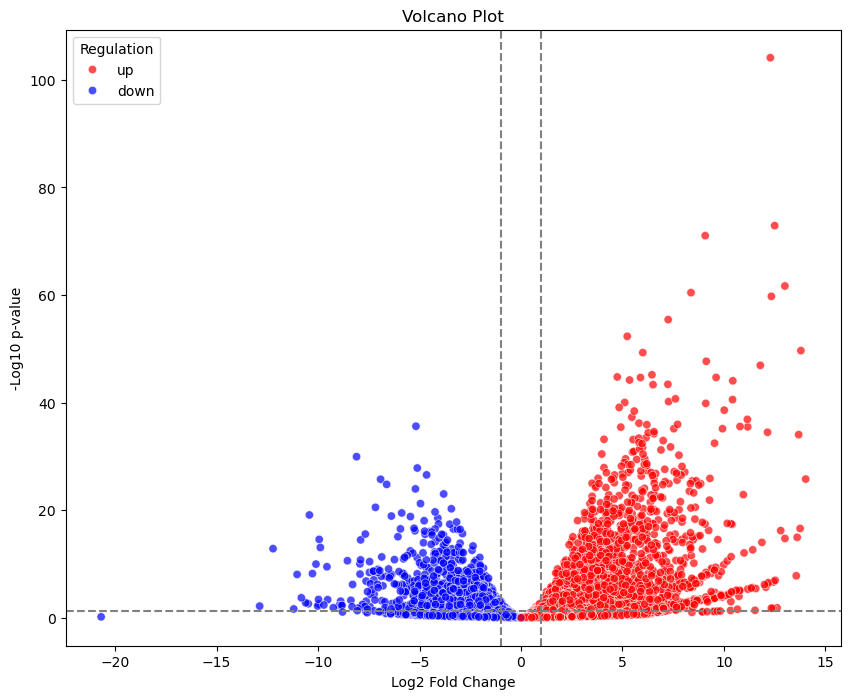

In [17]:
# Volcano plot
def volcano_plot(df):
    plt.figure(figsize=(10, 8))
    # Scatter plot of log2FoldChange vs -log10(pvalue)
    sns.scatterplot(x='log2FoldChange', y=-np.log10(df['pvalue']), data=df, hue='regulation', palette={'up': 'red', 'down': 'blue'}, alpha=0.7)
    plt.title('Volcano Plot')
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-Log10 p-value')
    plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')
    plt.axvline(x=1, color='grey', linestyle='--')
    plt.axvline(x=-1, color='grey', linestyle='--')
    plt.legend(title='Regulation')
    plt.show()

# Create the volcano plot
volcano_plot(df2)

# Save upregulated and downregulated genes
upregulated_genes = df2[df2['regulation'] == 'up']
downregulated_genes = df2[df2['regulation'] == 'down']

upregulated_genes.to_csv("upregulated_genes1.csv")
downregulated_genes.to_csv("downregulated_genes1.csv")

In [18]:
import streamlit as st
import pandas as pd
import altair as alt

st.set_page_config(page_title="Gene Expression Dashboard", layout="wide")

st.title("🧬 Gene Expression Explorer")

st.markdown("""
Upload your gene expression data and visualize expression levels across samples.
- Format: Rows = samples, Columns = genes
""")

uploaded_file = st.file_uploader("Upload your CSV file", type="csv")

if uploaded_file:
    df2 = pd.read_csv("deseq5_results.csv")

    if df2.shape[1] < 2:
        st.error("Please ensure the file contains at least one column for Sample IDs and one or more gene columns.")
    else:
        st.success("File uploaded successfully.")
        df2.columns = df2.columns.astype(str)
        st.dataframe(df2.head())

        sample_col = st.selectbox("Select sample ID column", df2.columns)
        gene_cols = [col for col in df2.columns if col != sample_col]

        gene = st.selectbox("Select a gene to visualize", gene_cols)

        chart_data = df2[[sample_col, gene]].copy()
        chart_data = chart_data.rename(columns={sample_col: "Sample", gene: "Expression"})

        st.altair_chart(
            alt.Chart(chart_data).mark_bar().encode(
                x=alt.X("Sample:N", sort=None),
                y="Expression:Q",
                tooltip=["Sample", "Expression"]
            ).properties(
                width=800,
                height=400,
                title=f"Expression Levels of {gene}"
            ),
            use_container_width=True
        )
else:
    st.info("Awaiting CSV file upload.")



2025-06-20 11:19:46.545 
  command:

    streamlit run c:\Users\fresh\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
